<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Анализ-корреляции-признаков" data-toc-modified-id="Анализ-корреляции-признаков-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Анализ корреляции признаков</a></span></li><li><span><a href="#Пайплайн-для-подготовки-данных" data-toc-modified-id="Пайплайн-для-подготовки-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Пайплайн для подготовки данных</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span><ul class="toc-item"><li><span><a href="#geo_data_0" data-toc-modified-id="geo_data_0-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>geo_data_0</a></span></li><li><span><a href="#geo_data_1" data-toc-modified-id="geo_data_1-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>geo_data_1</a></span></li><li><span><a href="#geo_data_2" data-toc-modified-id="geo_data_2-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>geo_data_2</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Выбор локации для скважины

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки

In [4]:
!pip -q install phik
!pip install scikit-learn --upgrade -q

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import phik
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

In [5]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [6]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [8]:
geo_data_0.info(), geo_data_1.info(), geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

(None, None, None)

Проверим строки-дубликаты

In [9]:
subset = [
    'f0',
    'f1',
    'f2',
    'product'
]
print(geo_data_0.duplicated(subset=subset).sum(), 
geo_data_1.duplicated(subset=subset).sum(),
geo_data_2.duplicated(subset=subset).sum())

0 0 0


Дубликатов не найдено

### Исследовательский анализ данных

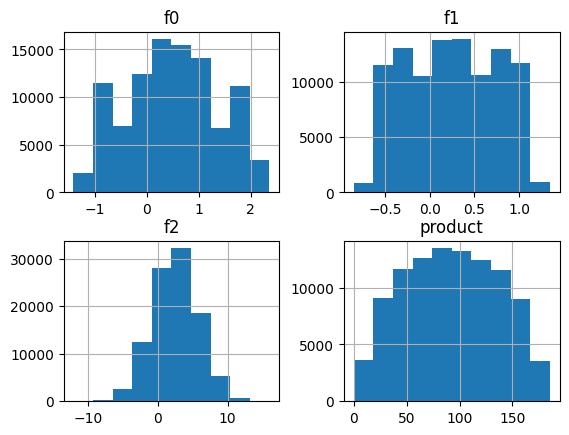

In [10]:
geo_data_0.hist();

Проверим нормальность распределений при помощи критерия Шапиро-Уилка

In [11]:
print(
    shapiro(geo_data_0['f0']).pvalue > 0.05,
    shapiro(geo_data_0['f1']).pvalue > 0.05,
    shapiro(geo_data_0['f2']).pvalue > 0.05,
    shapiro(geo_data_0['product']).pvalue > 0.05
)

False False False False


/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100000.
  res = hypotest_fun_out(*samples, **kwds)


Все распределение не нормальные, выбросов нет

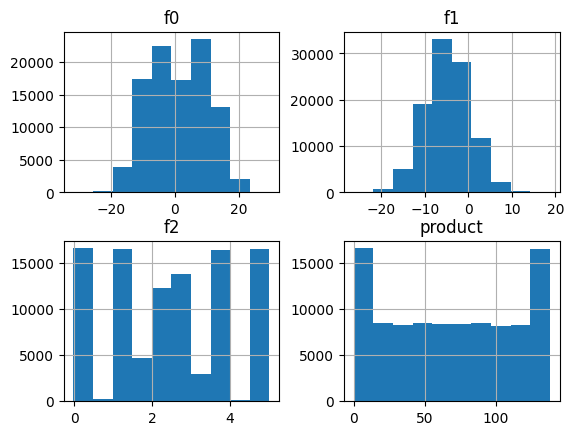

In [12]:
geo_data_1.hist();

Проверим нормальность распределений при помощи критерия Шапиро-Уилка

In [13]:
print(
    shapiro(geo_data_1['f0']).pvalue > 0.05,
    shapiro(geo_data_1['f1']).pvalue > 0.05,
    shapiro(geo_data_1['f2']).pvalue > 0.05,
    shapiro(geo_data_1['product']).pvalue > 0.05
)

False True False False


/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100000.
  res = hypotest_fun_out(*samples, **kwds)


Только признак f1 распределен нормально, выбросов нет.

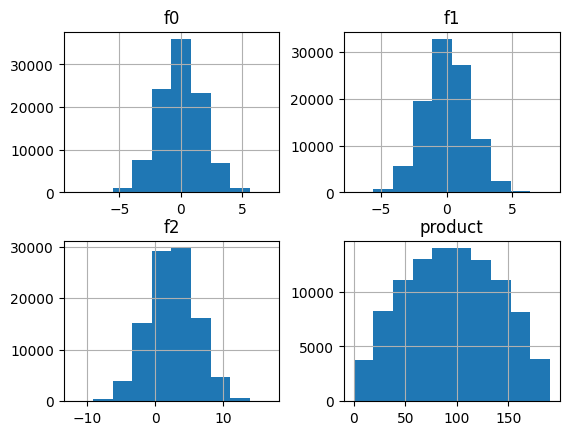

In [14]:
geo_data_2.hist();

Проверим нормальность распределений при помощи критерия Шапиро-Уилка

In [15]:
print(
    shapiro(geo_data_2['f0']).pvalue > 0.05,
    shapiro(geo_data_2['f1']).pvalue > 0.05,
    shapiro(geo_data_2['f2']).pvalue > 0.05,
    shapiro(geo_data_2['product']).pvalue > 0.05
)

True True False False


/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100000.
  res = hypotest_fun_out(*samples, **kwds)


Признаки f0 и f1 распределены нормально, выбросов нет.

### Анализ корреляции признаков

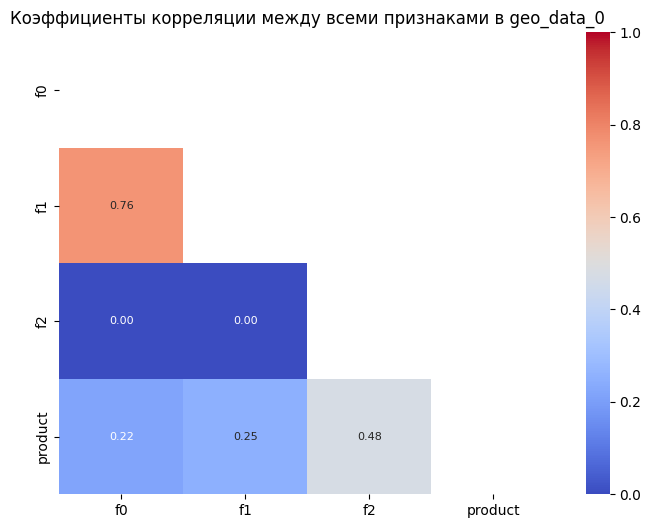

In [16]:
corr_matrix = geo_data_0.drop(columns=['id']).phik_matrix(
    interval_cols=[
        'f0',
        'f1',
        'f2',
        'product'
    ]
)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    annot_kws={"fontsize": 8}
)
plt.title('Коэффициенты корреляции между всеми признаками в geo_data_0')
plt.show()

Только f1 и f0 имеют сильную связь с коэффициентом 0.76. Мультиколлинеарности нет.

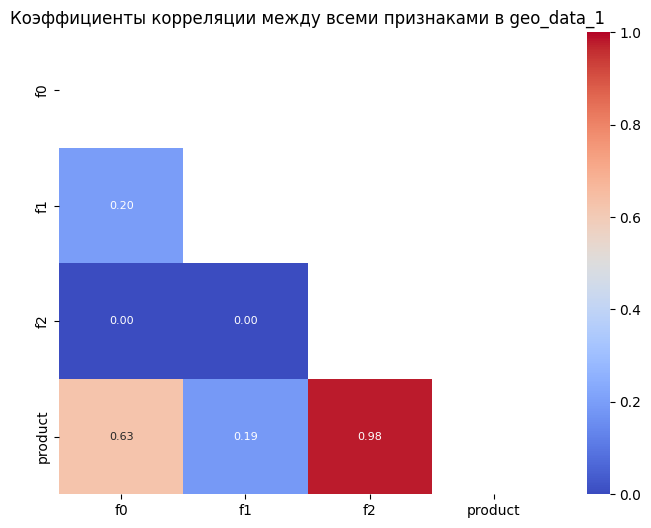

In [17]:
corr_matrix = geo_data_1.drop(columns=['id']).phik_matrix(
    interval_cols=[
        'f0',
        'f1',
        'f2',
        'product'
    ]
)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    annot_kws={"fontsize": 8}
)
plt.title('Коэффициенты корреляции между всеми признаками в geo_data_1')
plt.show()

f0 и product имеют среднюю связь. 
f2 и product имеют очень сильную связь, значит даже простая линейная модель сможет достичь хорошего качества

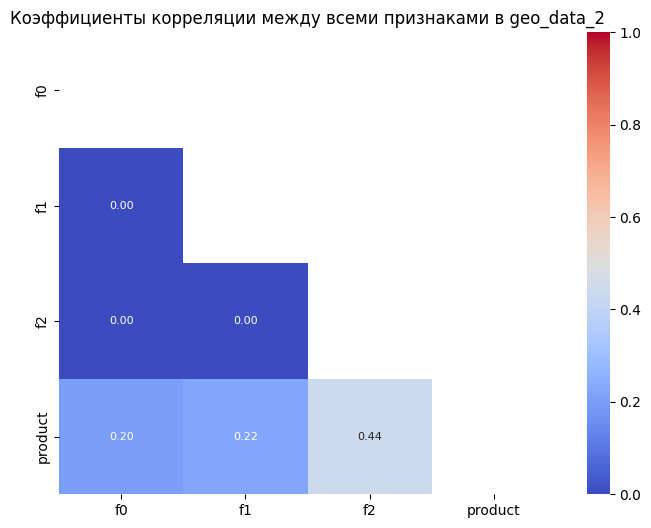

In [18]:
corr_matrix = geo_data_2.drop(columns=['id']).phik_matrix(
    interval_cols=[
        'f0',
        'f1',
        'f2',
        'product'
    ]
)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    annot_kws={"fontsize": 8}
)
plt.title('Коэффициенты корреляции между всеми признаками в geo_data_2')
plt.show()

Все связи незначительные. Мультиколлинеарности нет.

### Пайплайн для подготовки данных

Создадим списки с названиями признаков. Так как у нас все признаки числовые непрерывные признаки, нам нужен лишь список с ними.

In [19]:
num_columns = [
    'f0',
    'f1',
    'f2',
]

Cоздаём общий пайплайн для подготовки данных

In [20]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

## Обучение и проверка модели

### geo_data_0

Разделим данные на обучающую и валидационную выборки в соотношении 75:25.

In [21]:
geo_data_0_X = geo_data_0.drop(columns=['id', 'product'])
geo_data_0_y = geo_data_0['product']

In [22]:
geo_data_0_X_train, geo_data_0_X_valid, geo_data_0_y_train, geo_data_0_y_valid = train_test_split(
    geo_data_0_X,
    geo_data_0_y,
    test_size=0.25,
    random_state=42
)

Для обучения будем использовать линейную регрессию, так как остальные модели недостаточно предсказуемые.

In [23]:
pipe_final_0 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [24]:
pipe_final_0.fit(geo_data_0_X_train, geo_data_0_y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])

Сдалаем предсказания на валиадационной выборке

In [25]:
predictions_0 = pipe_final_0.predict(geo_data_0_X_valid)

Посчитаем средний запас предсказанного сырья

In [26]:
predictions_0.mean()

np.float64(92.39879990657768)

Посчитаем RMSE

In [27]:
root_mean_squared_error(geo_data_0_y_valid, predictions_0)

np.float64(37.75660035026169)

Посмотрим на основные характеристики распределения целевого признака

In [28]:
geo_data_0_y_valid.describe()

count    25000.000000
mean        92.325956
std         44.277512
min          0.021781
25%         56.300099
50%         90.785176
75%        128.117571
max        185.355615
Name: product, dtype: float64

Средний запас предсказанного сырья равен 92 (у настоящих данных оно отличается на 0.07, что является хорошим результатом), RMSE = 37 (ошибка заметная, но незначительная, что не мешает более-менее точно прогнозировать запас сырья)

### geo_data_1

Совершим действия, аналогичные пункту geo_data_0

In [29]:
geo_data_1_X = geo_data_1.drop(columns=['id', 'product'])
geo_data_1_y = geo_data_1['product']

In [30]:
geo_data_1_X_train, geo_data_1_X_valid, geo_data_1_y_train, geo_data_1_y_valid = train_test_split(
    geo_data_1_X,
    geo_data_1_y,
    test_size=0.25,
    random_state=42
)

In [31]:
pipe_final_1 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [32]:
pipe_final_1.fit(geo_data_1_X_train, geo_data_1_y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])

In [33]:
predictions_1 = pipe_final_1.predict(geo_data_1_X_valid)

In [34]:
predictions_1.mean()

np.float64(68.7128780391376)

In [35]:
root_mean_squared_error(geo_data_1_y_valid, predictions_1)

np.float64(0.8902801001028839)

In [36]:
geo_data_1_y_valid.describe()

count    25000.000000
mean        68.725381
std         45.945586
min          0.000000
25%         30.132364
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64

Средний запас предсказанного сырья равен 68 (у настоящих данных оно отличается на 0.05, что является хорошим результатом), RMSE = 0.89 (это очень хороший результат)

### geo_data_2

Совершим действия, аналогичные пункту geo_data_0 и geo_data_1

In [37]:
geo_data_2_X = geo_data_2.drop(columns=['id', 'product'])
geo_data_2_y = geo_data_2['product']

In [38]:
geo_data_2_X_train, geo_data_2_X_valid, geo_data_2_y_train, geo_data_2_y_valid = train_test_split(
    geo_data_2_X,
    geo_data_2_y,
    test_size=0.25,
    random_state=42
)

In [39]:
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [40]:
pipe_final_2.fit(geo_data_2_X_train, geo_data_2_y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])

In [41]:
predictions_2 = pipe_final_2.predict(geo_data_2_X_valid)

In [42]:
predictions_2.mean()

np.float64(94.77102387765939)

In [43]:
root_mean_squared_error(geo_data_2_y_valid, predictions_2)

np.float64(40.14587231134218)

In [44]:
geo_data_2_y_valid.describe()

count    25000.000000
mean        95.150999
std         44.783220
min          0.019327
25%         59.666842
50%         94.936982
75%        130.566313
max        190.011722
Name: product, dtype: float64

Средний запас предсказанного сырья равен 94 (у настоящих данных оно отличается на 0.38, что является неплохим результатом), RMSE = 40 (ошибка заметная, но незначительная, что не мешает более-менее точно прогнозировать запас сырья)

Среди трех регионов лучшее среднее предсказано у последнего - 94.77. Лучшая RMSE у второго региона.

## Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраним в отдельных переменных.

In [45]:
BUDGET = 10_000_000_000
BARREL_PRICE_1000 = 450_000
WELLS_BEST = 200
WELLS_TOTAL = 500

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [46]:
min_oil_required = BUDGET / (BARREL_PRICE_1000 * WELLS_BEST)
min_oil_required

111.11111111111111

Достаточный объём сырья для безубыточности равен 111 тыс. баррелей нефти.

Сравним полученный объём сырья со средним запасом в каждом регионе

In [47]:
average_oil_geo_data_0 = geo_data_0['product'].mean()
average_oil_geo_data_1 = geo_data_1['product'].mean()
average_oil_geo_data_2 = geo_data_2['product'].mean()

average_oil_geo_data_0, average_oil_geo_data_1, average_oil_geo_data_2

(np.float64(92.50000000000001),
 np.float64(68.82500000000002),
 np.float64(95.00000000000004))

Средний запас ниже рассчитанного минимального объёма, разрабатывать невыгодно. Для безубыточности каждая выбранная скважина должна давать не менее 111.11 тыс. баррелей нефти.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- Выбор скважины с максимальными значениями предсказаний. 
- Сумма целевого значения объёма сырья, соответствующего этим предсказаниям.
- Рассчет прибыли для полученного объёма сырья.

In [48]:
def calculate_profit(target, predictions):
    df = pd.DataFrame({
        'target': target,
        'predictions': predictions
    }) 
    df = df.sort_values(by='predictions', ascending=False)
    df = df.head(200)
    total_oil = df['target'].sum()
    return total_oil * BARREL_PRICE_1000 - BUDGET


Создадим списки с предсказаниями для всех скважин из каждого региона

In [49]:
predictions_0 = pipe_final_0.predict(geo_data_0_X)
predictions_1 = pipe_final_1.predict(geo_data_1_X)
predictions_2 = pipe_final_2.predict(geo_data_2_X)

Создадим функцию для бутстреппирования

In [62]:
def bootstrap(target, predictions):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=WELLS_TOTAL, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        profit = calculate_profit(target_subsample, predictions_subsample)
        values.append(profit)
        
    values = pd.Series(values)
    mean_profit = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    print('Средняя прибыль:', mean_profit, 'тыс. баррелей')
    print('95% доверительный интервал: (', lower,';', upper, ')')
    print('Риск убытка:', (values < 0).mean())
    print(' ')

In [63]:
bootstrap(geo_data_0_y, predictions_0)

Средняя прибыль: 378782043.7469342 тыс. баррелей
95% доверительный интервал: ( -128951531.6730843 ; 932399914.5737809 )
Риск убытка: 0.075
 


In [64]:
bootstrap(geo_data_1_y, predictions_1)

Средняя прибыль: 402367396.17646116 тыс. баррелей
95% доверительный интервал: ( 212384.5523695591 ; 736126600.4714712 )
Риск убытка: 0.025
 


In [65]:
bootstrap(geo_data_2_y, predictions_2)

Средняя прибыль: 374728178.2054335 тыс. баррелей
95% доверительный интервал: ( -167255058.77871084 ; 894085505.1283832 )
Риск убытка: 0.09
 


Лучший регион для разработки скважины - второй (geo_data_1), так как у него самая большая средняя прибыль,  риск убытка ниже, чем у остальных.

## Выводы

Ход работы:
- Загружены и предобработаны данные. В ходе предобработки данных не были обнаружены дубликаты.
- Проведен исследовательский анализ данных. В ходе исследовательского анализа данных не выявлено выбросов и аномалий. Все признаки непрерывные. 
- Был проведен анализ корреляции признаков: 
    - Первый регион: Только f1 и f0 имеют сильную связь с коэффициентом 0.76. Мультиколлинеарности нет.
    - Второй регион: f0 и product имеют среднюю связь. f2 и product имеют очень сильную связь, значит даже простая линейная модель сможет достичь хорошего качества
    - Третий регион: Все связи незначительные. Мультиколлинеарности нет.
- Данные были подготовлены в пайплайне подготовки данных
- В ходе обучения моделей выяснилось:
    - Первый регион: Средний запас предсказанного сырья равен 92 (у настоящих данных оно отличается на 0.07, что является хорошим результатом), RMSE = 37 (ошибка заметная, но незначительная, что не мешает более-менее точно прогнозировать запас сырья)
    - Второй регион: Средний запас предсказанного сырья равен 68 (у настоящих данных оно отличается на 0.05, что является хорошим результатом), RMSE = 0.89 (это очень хороший результат)
    - Третий регион: Средний запас предсказанного сырья равен 94 (у настоящих данных оно отличается на 0.38, что является неплохим результатом), RMSE = 40 (ошибка заметная, но незначительная, что не мешает более-менее точно прогнозировать запас сырья)
- Были посчитаны риски и прибыль с каждого региона. Лучший регион для разработки скважины - второй (geo_data_1), так как у него самая большая средняя прибыль,  риск убытка ниже, чем у остальных.